# $ \frac{dy}{dx} = f_0(x) + f_1(x)y + f_2(x)y^2 + ...$  の解法

## ①初期設定（解法共通）

In [1]:
from import_summary import *
from utility import *  # 計算基底に関する確率分布を表示
from HHL_function import *  # HHL algorithmに必要な関数

In [2]:
# 多項式(の係数)list1と多項式(の係数)list2の掛け算、十分要素数が確保されているならenough=1
def times_list(list1, list2, enough=1):
    result = np.zeros(len(list1) + len(list2) - 1)
    for i in range(len(list1)):
        for j in range(len(list2)):
            result[i + j] += list1[i] * list2[j]

    # list_1とlist_2の要素数は同じで、かつ配列の長さが十分のとき
    if enough == 1:
        result = result[:len(list1)]

    return result


# 多項式(の係数)listの微分
def differential(list):
    result = np.zeros(len(list))
    for i in range(len(list) - 1):
        result[i] = (i + 1) * list[i + 1]

    return result


## ②解きたい微分方程式の設定、刻み幅、次元数、補助qubit数の設定

In [3]:
# 各パラメータ
number = 3
scale_fac = 1.0
reg_nbit_list = np.array([9, 10, 11])  # 位相推定に使うレジスタの数(10,11,12)

if number == 0:
    # dy/dx = -2(y-1)
    h = 0.05  # 刻み幅
    n = 200  # 考える区間[x_first, x_first + h*(n-1)]
    order = 1
    x_list = np.array([h * i for i in range(n)])
    y_exact = np.exp(-2 * x_list) + 1
    y_first = copy(y_exact)


elif number == 1:
    # dy/dx = -2x(y-1)
    h = 0.05  # 刻み幅
    n = 100  # 考える区間[x_first, x_first + h*(n-1)]
    order = 1
    x_list = np.array([h * i for i in range(n)])
    y_exact = np.exp(-x_list ** 2) + 1
    y_first = copy(y_exact)


elif number == 2:
    # dy/dx = -2x(y-2)^2-4(y-2)
    h = 0.01  # 刻み幅
    n = 100  # 考える区間[x_first, x_first + h*(n-1)]
    order = 2
    x_list = np.array([h * i for i in range(n)])
    y_exact = 2 - 8 / (7 * np.exp(4 * x_list) + 4 * x_list + 1)
    y_first = copy(y_exact)


elif number == 3:
    h = 0.01  # 刻み幅
    n = 100  # 考える区間[x_first, x_first + h*(n-1)]
    order = 3
    x_list = np.array([h * i for i in range(n)])
    y_exact = 2 + 1 / np.sqrt(4 + 2 * x_list ** 2)  # dy/dx = -2x(y-2)^3
    y_first = copy(y_exact)


def function(x):
    if number == 0:
        return np.array([2, -2])
    elif number == 1:
        return np.array([2 * x, -2 * x])

    elif number == 2:
        return np.array([-8 * x + 8, 8 * x - 4, -2 * x])

    elif number == 3:
        return np.array([16 * x, -24 * x, 12 * x, -2 * x])  # dy/dx = -2x(y-2)^3


depth = int(np.floor(np.log2(n)))

## ③Runge-Kutta法による解法

In [ ]:
y_runge4 = np.zeros(len(x_list))  # 初期条件
y_runge4[0] = y_first[0]
start = time.time()
for i in range(len(x_list) - 1):
    k_1 = 0
    for j in range(1 + order):
        k_1 += h * function(x_list[i])[j] * (y_runge4[i] ** j)

    k_2 = 0
    for j in range(1 + order):
        k_2 += h * function(x_list[i] + h / 2)[j] * (y_runge4[i] + k_1 / 2) ** j

    k_3 = 0
    for j in range(1 + order):
        k_3 += h * function(x_list[i] + h / 2)[j] * (y_runge4[i] + k_2 / 2) ** j

    k_4 = 0
    for j in range(1 + order):
        k_4 += h * function(x_list[i] + h)[j] * (y_runge4[i] + k_3) ** j

    k = (k_1 + 2 * k_2 + 2 * k_3 + k_4) / 6

    y_runge4[i + 1] = y_runge4[i] + k

t = time.time() - start

with open("1階ODE数値結果/number=" + str(number) + "/RUNGE_EXACT(number=" + str(number) + ",h=" + str(
        h) + ",n=" + str(n) + ").csv", 'w', newline='') as f:
    writer = csv.writer(f)
    for i in range(n):
        writer.writerow([x_list[i], y_runge4[i]])

print("Runge-Kutta calculation completed.")
print("Elapsed time[s]:", t)
print("number:", number, "h:", h, " n:", n, "\n")

## ④Newton法による古典計算

In [ ]:
def jacobi_newton(x, diff_k_coef_newton):
    jacobi = np.eye(n)
    for i in range(n - 1):
        jacobi[i + 1][i] = -1
        for j in range(1 + order ** 4):
            jacobi[i + 1][i] += -diff_k_coef_newton[i][j] * (x[i] ** j)

    return jacobi


def right_side_newton(x, k_coef_newton):
    formula = np.array([0])
    for i in range(n - 1):
        k_poly = 0
        for j in range(1 + order ** 4):
            k_poly += k_coef_newton[i][j] * (x[i] ** j)

        formula = np.append(formula, -x[i + 1] + x[i] + k_poly)

    return formula


###################### Runge-kutta法(4次・Newton)専用 ######################
# newton_first = copy(y_first)  # 初期条件
# for i in range(1, len(newton_first)):
#     newton_first[i] += random.uniform(e, -e)

newton_first = np.array([y_first[0] for i in range(len(x_list))])  # 初期条件

k_coef_newton = np.zeros((n, 1 + order ** 4))
diff_k_coef_newton = np.zeros((n, 1 + order ** 4))
func_value = np.zeros((1 + order, 3))

start = time.time()
for _ in tqdm.tqdm(range(depth)):
    for i in range(n - 1):
        # 関数の値を計算
        for l in range(1 + order):
            for m in range(3):
                func_value[l][m] = function(x_list[i] + m * h / 2)[l]

        k_1 = np.zeros(1 + order ** 4)
        k_2 = np.zeros(1 + order ** 4)
        k_3 = np.zeros(1 + order ** 4)
        k_4 = np.zeros(1 + order ** 4)
        k = np.zeros(1 + order ** 4)

        for l in range(1 + order):
            k_1[l] = h * func_value[l][0]

        k += k_1 / 6.0

        k_1 = k_1 / 2
        k_1[1] += 1
        k_temp = np.zeros(1 + order ** 4)
        k_temp[0] = 1
        for l in range(1 + order):
            k_2 += h * func_value[l][1] * k_temp
            k_temp = times_list(k_1, k_temp)

        k += k_2 / 3.0

        k_2 = k_2 / 2
        k_2[1] += 1
        k_temp = np.zeros(1 + order ** 4)
        k_temp[0] = 1
        for l in range(1 + order):
            k_3 += h * func_value[l][1] * k_temp
            k_temp = times_list(k_2, k_temp)

        k += k_3 / 3.0

        k_3[1] += 1
        k_temp = np.zeros(1 + order ** 4)
        k_temp[0] = 1
        for l in range(1 + order):
            k_4 += h * func_value[l][2] * k_temp
            k_temp = times_list(k_3, k_temp)

        k += k_4 / 6.0
        k_coef_newton[i] = k  # i番目のkを多項式で表示したときの係数
        diff_k_coef_newton[i] = differential(k)  # i番目のdk/dyを多項式で表示したときの係数

    jacobi_matrix_newton = jacobi_newton(newton_first, diff_k_coef_newton)
    right_newton = right_side_newton(newton_first, k_coef_newton)

    Delta = np.linalg.lstsq(jacobi_matrix_newton, right_newton, rcond=0)[0]
    newton_first += Delta

t = time.time() - start
y_exact_newton = newton_first

with open(
        "1階ODE数値結果/number=" + str(number) + "/NEWTON_EXACT(number=" + str(number) + ",h=" + str(
            h) + ",n=" + str(n) + ").csv", 'w', newline='') as f:
    writer = csv.writer(f)
    for i in range(n):
        writer.writerow([x_list[i], y_exact_newton[i]])

print("Newton calculation completed.")
print("Elapsed time[s]:", t)
print("number:", number, "h:", h, " n:", n, "\n")

  1%|          | 1/100 [00:00<00:04, 19.98it/s]

Newton calculation completed.
Elapsed time[s]: 0.05405783653259277
number: 0 h: 0.05  n: 100  e: 1  tol: 1e-10
Number of updates: 1 



## ③HHL algorithmによる解法

In [2]:
def jacobi_HHL(x, diff_k_coef_HHL):
    jacobi = np.eye(n)
    for i in range(n - 1):
        jacobi[i + 1][i] = -1
        for j in range(1 + order ** 4):
            jacobi[i + 1][i] += -diff_k_coef_HHL[i][j] * (x[i] ** j)

    return jacobi


def right_side_HHL(x, k_coef_HHL):
    formula = np.array([0])
    for i in range(n - 1):
        k_poly = 0
        for j in range(1 + order ** 4):
            k_poly += k_coef_HHL[i][j] * (x[i] ** j)

        formula = np.append(formula, -x[i + 1] + x[i] + k_poly)

    return formula


###################### Runge-kutta法(4次・HHL)専用 ######################
# HHL_first = copy(y_first)  # 初期条件
# for i in range(1, len(HHL_first)):
#    HHL_first[i] += random.uniform(e, -e)
HHL_runge_result = np.zeros((len(reg_nbit_list), n))
k_coef_HHL = np.zeros((n, 1 + order ** 4))
diff_k_coef_HHL = np.zeros((n, 1 + order ** 4))
func_value = np.zeros((1 + order, 3))

for i in range(n - 1):
    # 関数の値を計算
    for l in range(1 + order):
        for m in range(3):
            func_value[l][m] = function(x_list[i] + m * h / 2)[l]

    k_1 = np.zeros(1 + order ** 4)
    k_2 = np.zeros(1 + order ** 4)
    k_3 = np.zeros(1 + order ** 4)
    k_4 = np.zeros(1 + order ** 4)
    k = np.zeros(1 + order ** 4)

    for l in range(1 + order):
        k_1[l] = h * func_value[l][0]

    k += k_1 / 6.0

    k_1 = k_1 / 2
    k_1[1] += 1
    k_temp = np.zeros(1 + order ** 4)
    k_temp[0] = 1
    for l in range(1 + order):
        k_2 += h * func_value[l][1] * k_temp
        k_temp = times_list(k_1, k_temp)

    k += k_2 / 3.0

    k_2 = k_2 / 2
    k_2[1] += 1
    k_temp = np.zeros(1 + order ** 4)
    k_temp[0] = 1
    for l in range(1 + order):
        k_3 += h * func_value[l][1] * k_temp
        k_temp = times_list(k_2, k_temp)

    k += k_3 / 3.0

    k_3[1] += 1
    k_temp = np.zeros(1 + order ** 4)
    k_temp[0] = 1
    for l in range(1 + order):
        k_4 += h * func_value[l][2] * k_temp
        k_temp = times_list(k_3, k_temp)

    k += k_4 / 6.0
    k_coef_HHL[i] = k  # i番目のkを多項式で表示したときの係数
    diff_k_coef_HHL[i] = differential(k)  # i番目のdk/dyを多項式で表示したときの係数

for index, reg_nbit in enumerate(reg_nbit_list):
    HHL_first = np.array([y_first[0] for i in range(len(x_list))])  # 初期条件

    # Wx=cに直す
    start = time.time()
    for _ in tqdm.tqdm(range(depth)):
        J_HHL = jacobi_HHL(HHL_first, diff_k_coef_HHL)  # Jacobi行列を計算
        b_HHL = right_side_HHL(HHL_first, k_coef_HHL)  # 連立方程式の右辺

        # Wは必ずHermiteではないので[[0,W],[W^T,0]]、[b,0]にする
        dim = 2 * n
        J_HHL = np.block([[np.zeros((n, n)), J_HHL], [J_HHL.T, np.zeros((n, n))]])  # 2n*2n次元の行列
        b_HHL = np.block([b_HHL, np.zeros(n)])  # 2n次元のベクトル
        # Wの固有値を確認 -> [-pi, pi] に収まっている
        for value in np.linalg.eigh(J_HHL)[0]:
            if value < -np.pi or np.pi < value:
                print("caution:eigenvalues exist that are not included in [-π,π].")
                exit(1)

        y_HHL = HHL_algorithm(J_HHL, b_HHL, dim, reg_nbit, scale_fac)
        HHL_first += y_HHL[n:2 * n]

    t = time.time() - start
    HHL_runge_result[index] = HHL_first

    with open("1階ODE数値結果/number=" + str(number) + "/HHL(number=" + str(number) + ",reg_qubits=" + str(reg_nbit) + ",h=" + str(
            h) + ",n=" + str(n) + ").csv", 'w', newline='') as f:
        writer = csv.writer(f)
        for i in range(n):
            writer.writerow([x_list[i], HHL_runge_result[index][i]])

    print("HHL calculation completed.")
    print("Elapsed time[s]:", t)
    print("register qubits:", reg_nbit)
    print("number:", number, "h:", h, " n:", n, "\n")

NameError: name 'np' is not defined

## ⑦それぞれのグラフ・相対誤差

In [ ]:
HHL_runge_result = np.zeros((len(reg_nbit_list), n))
y_exact_newton = np.zeros(n)
y_runge4 = np.zeros(n)

# データ読み込み
for index, reg_nbit in enumerate(reg_nbit_list):
    with open("1階ODE数値結果/number=" + str(number) + "/HHL(number=" + str(number) + ",reg_qubits=" + str(reg_nbit) + ",h=" + str(
            h) + ",n=" + str(n) + ").csv", newline="") as f:
        reader = csv.reader(f)
        for i, row in enumerate(reader):
            HHL_runge_result[index][i] = row[1]

with open("1階ODE数値結果/number=" + str(number) + "/NEWTON_EXACT(number=" + str(number) + ",h=" + str(
        h) + ",n=" + str(n) + ").csv", newline="") as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        y_exact_newton[i] = row[1]

with open("1階ODE数値結果/number=" + str(number) + "/RUNGE_EXACT(number=" + str(number) + ",h=" + str(
        h) + ",n=" + str(n) + ").csv", newline="") as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        y_runge4[i] = row[1]

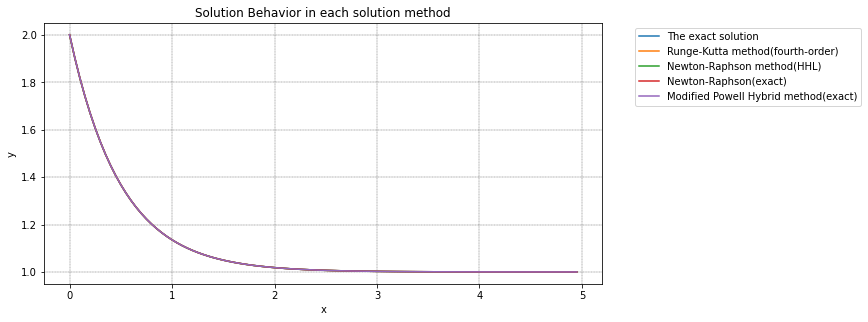

In [ ]:
fig = plt.figure(figsize=(10, 4.8))
plt.plot(x_list, y_exact, label="The exact solution", color="black")  # 厳密解をプロット
plt.plot(x_list, HHL_runge_result[0],
         label="Newton-Raphson method(HHL,reg=" + str(reg_nbit_list[0]) + ")", color="red")  # オイラー法(厳密)で求めた近似解をプロット
plt.plot(x_list, HHL_runge_result[1],
         label="Newton-Raphson method(HHL,reg=" + str(reg_nbit_list[1]) + ")", color="orange")  # オイラー法(厳密)で求めた近似解をプロット
plt.plot(x_list, HHL_runge_result[2],
         label="Newton-Raphson method(HHL,reg=" + str(reg_nbit_list[2]) + ")", color="blue")  # オイラー法(厳密)で求めた近似解をプロット
plt.plot(x_list, y_exact_newton, label="Newton-Raphson(exact)", color="green")  # オイラー法(HHL)で求めた近似解をプロット
plt.plot(x_list, y_runge4, label="Runge-Kutta method(fourth-order)", color="brown")  # 4次のルンゲクッタ法(厳密)で求めた近似解をプロット

plt.title("Solution Behavior in each solution method")
plt.grid(color="black", linestyle='--', linewidth=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large')

plt.xlabel("x")
plt.ylabel("y")
fig.savefig("1階ODE数値結果/number=" + str(number) + "/plot(number=" + str(number) + ",reg_qubits=" + str(reg_nbit_list) + ",h=" + str(
    h) + ",n=" + str(n) + ").png", bbox_inches="tight")
plt.show()


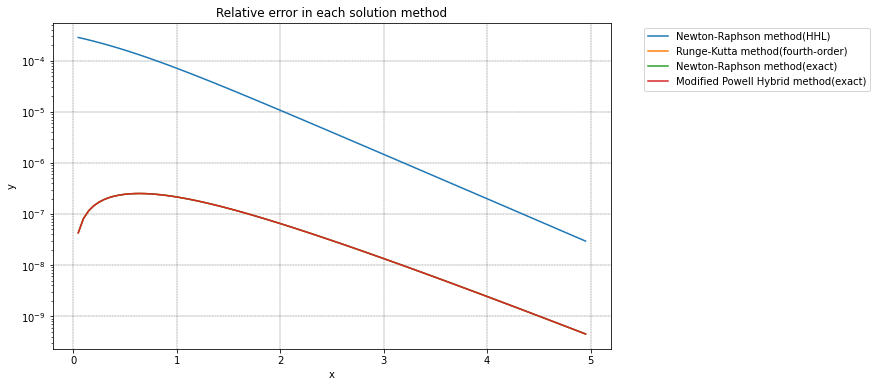

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.plot(x_list, abs((HHL_runge_result[0] - y_exact) / y_exact),
         label="Newton-Raphson method(HHL,reg=" + str(reg_nbit_list[0]) + ")", color="red")  # オイラー法(厳密)で求めた近似解をプロット
plt.plot(x_list, abs((HHL_runge_result[1] - y_exact) / y_exact),
         label="Newton-Raphson method(HHL,reg=" + str(reg_nbit_list[1]) + ")", color="orange")  # オイラー法(厳密)で求めた近似解をプロット
plt.plot(x_list, abs((HHL_runge_result[2] - y_exact) / y_exact),
         label="Newton-Raphson method(HHL,reg=" + str(reg_nbit_list[2]) + ")", color="blue")  # オイラー法(厳密)で求めた近似解をプロット
plt.plot(x_list, abs((y_runge4 - y_exact) / y_exact),
         label="Runge-Kutta method(fourth-order)", color="brown")  # 4次のルンゲクッタ法(厳密)で求めた近似解をプロット
plt.plot(x_list, abs((y_exact_newton - y_exact) / y_exact),
         label="Newton-Raphson method(exact)", color="green")  # オイラー法(HHL)で求めた近似解をプロット

plt.title("Relative error in each solution method")
plt.grid(color="black", linestyle='--', linewidth=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large')

plt.xlabel("x")
plt.ylabel("y")
plt.yscale("log")
fig.savefig(
    "1階ODE数値結果/number=" + str(number) + "/error(number=" + str(number) + ",reg_qubits=" + str(reg_nbit_list) + ",h=" + str(
        h) + ",n=" + str(n) + ").png", bbox_inches="tight")
plt.show()